In [1]:
from collections import Counter
import os
import sys

from kmeans_pytorch import kmeans, kmeans_predict
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

In [2]:
class NoPrint:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

def encoder_net(h):
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, h),
        nn.Tanh(),
    )

class BaseNet(nn.Module):
    def __init__(self, h):
        super(BaseNet, self).__init__()
        self.encoder_net = encoder_net(h)
        self.linear = nn.Linear(h, 10)
        self.softmax = nn.Softmax(-1)

    def forward(self, x):
        raise NotImplementedError
    
    def process_k_means(self, dataset, device='cpu'):
        with NoPrint():
            _, self.cluster_centers = kmeans(
                X=self.encoder_net.to(device)(dataset.data.float().to(device)),
                num_clusters=10, distance='euclidean', device=device,
                tqdm_flag=False)
        self.cluster_to_digit = {}
        pred = self.encoder_net.to(device)(dataset.data.float().to(device))
        for i, center in enumerate(self.cluster_centers):      
            digit = torch.argmin(torch.Tensor([
                torch.cdist(
                    center.unsqueeze(0).to(device),
                    pred[dataset.targets==j])[0].mean() for j in range(10)]))
            self.cluster_to_digit[i] = digit.item()

    def classify(self, x, device='cpu'):
        if self.cluster_centers is None:
            raise ValueError("Use .process_k_means(data) first")
        with NoPrint():
            cluster_ids_x = kmeans_predict(
                self.encoder_net.to(device)(x.float().to(device)),
                self.cluster_centers,
                'euclidean', device=device)
        digits_x = torch.Tensor([
            self.cluster_to_digit[cluster_id.item()]
            for cluster_id in cluster_ids_x])
        return digits_x
    
    def accuracy(self, dataset, device='cpu'):
        preds = self.classify(dataset.data.float())
        acc = torch.sum(preds == dataset.targets)/len(preds)
        return acc.item()


class HebbianNet(BaseNet):
    def __init__(self, h):
        super(HebbianNet, self).__init__(h)
    
    def forward(self, x):
        with torch.no_grad():
            x = self.encoder_net(x)
        return x


class SupervisedNet(BaseNet):
    def __init__(self, h):
        super(SupervisedNet, self).__init__(h)
        self.linear = nn.Linear(h, 10)
        self.softmax = nn.Softmax(-1)

    def forward(self, x):
        x = self.encoder_net(x)
        x = self.linear(x)
        return self.softmax(x)


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

nb_epochs = 80
lr = 0.05
batch_size = 32
h = 300

In [4]:
hebbian_net = HebbianNet(h).to(device)
supervised_net = SupervisedNet(h).to(device)

In [5]:
train_set = MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
train_set, valid_set = random_split(train_set, [50000, 10000])
test_set = MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

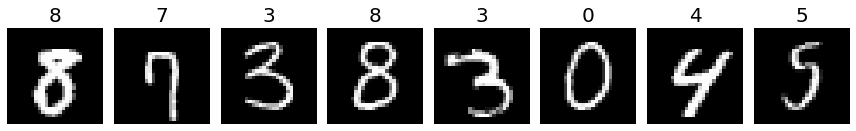

In [6]:
# Visualization of train set
for images, labels in train_loader:
    plt.figure(figsize=(12,4))
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(images[i,0], cmap='gray')
        plt.axis('off')
        plt.title(labels[i].item(), fontsize=20)
    plt.tight_layout()
    break

In [7]:
hebbian_net.process_k_means(train_set.dataset, device=device)
acc = hebbian_net.accuracy(train_set.dataset, device=device)
print(f'Accuracy: {acc:.3f}')

Accuracy: 0.572


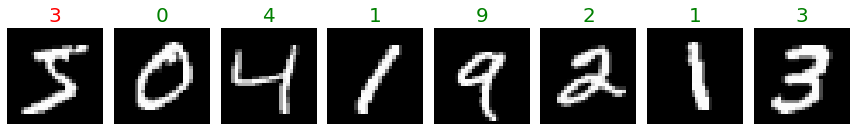

In [8]:
plt.figure(figsize=(12,4))
preds = hebbian_net.classify(train_set.dataset.data[:8], device=device).int()
colors = [['red', 'green'][correct] for correct in train_set.dataset.targets[:8]==preds]
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(train_set.dataset.data[i], cmap='gray')
    plt.axis('off')
    plt.title(preds[i].item(), fontsize=20, color=colors[i])
plt.tight_layout()


In [9]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(supervised_net.parameters(), lr=lr)

In [14]:
def train_epoch(model, train_loader, criterion, optim, device):
    epoch_loss = 0.
    for images, labels in train_loader:
        output = model.to(device)(images.to(device))
        loss = criterion(output, labels.to(device))
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_loss += loss.item()
    return epoch_loss / (len(train_loader)*train_loader.batch_size)

def accuracy(model, loader, device):
    acc = 0
    for images, labels in loader:
        output = model.to(device)(images.to(device))
        pred = torch.argmax(output, -1)
        acc += torch.sum(pred == labels.to(device)).item()
    return acc / (len(loader)*loader.batch_size)

def train(model, train_loader, valid_loader, criterion, optim, nb_epochs, device):
    for epoch in range(nb_epochs):
        epoch_loss = train_epoch(model, train_loader, criterion, optim, device)
        train_acc = accuracy(model, train_loader, device)
        valid_acc = accuracy(model, valid_loader, device)
        model.process_k_means(train_loader.dataset.dataset, device=device)
        k_means_train_acc = model.accuracy(train_loader.dataset.dataset, device=device)
        print(f"[Epoch {epoch+1:2d}]  loss: {epoch_loss:.4f}  train_acc: {train_acc:.3f}  valid_acc: {valid_acc:.3f}  k-means_train_acc: {k_means_train_acc:.3f}")

In [11]:
train(supervised_net, train_loader, valid_loader, criterion, optim, nb_epochs, device)

[Epoch  1]  loss: 0.0578  train_acc: 0.823  valid_acc: 0.820  k-means_train_acc: 0.814
[Epoch  2]  loss: 0.0505  train_acc: 0.899  valid_acc: 0.893  k-means_train_acc: 0.811
[Epoch  3]  loss: 0.0493  train_acc: 0.909  valid_acc: 0.905  k-means_train_acc: 0.829
[Epoch  4]  loss: 0.0489  train_acc: 0.916  valid_acc: 0.909  k-means_train_acc: 0.749
[Epoch  5]  loss: 0.0487  train_acc: 0.920  valid_acc: 0.912  k-means_train_acc: 0.753
[Epoch  6]  loss: 0.0485  train_acc: 0.923  valid_acc: 0.916  k-means_train_acc: 0.755
[Epoch  7]  loss: 0.0484  train_acc: 0.926  valid_acc: 0.917  k-means_train_acc: 0.831
[Epoch  8]  loss: 0.0483  train_acc: 0.928  valid_acc: 0.919  k-means_train_acc: 0.831
[Epoch  9]  loss: 0.0482  train_acc: 0.930  valid_acc: 0.920  k-means_train_acc: 0.915
[Epoch 10]  loss: 0.0481  train_acc: 0.932  valid_acc: 0.921  k-means_train_acc: 0.916
[Epoch 11]  loss: 0.0480  train_acc: 0.935  valid_acc: 0.924  k-means_train_acc: 0.917
[Epoch 12]  loss: 0.0480  train_acc: 0.936 

Accuracy on test set: 0.967


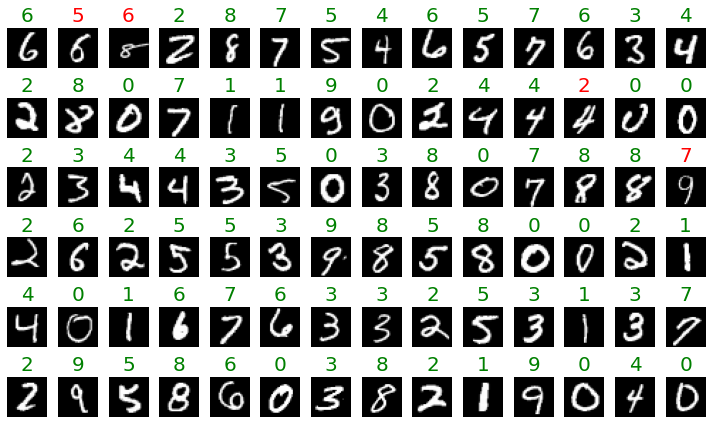

In [12]:
# Predictions on test set

plt.figure(figsize=(10,6))
n_rows = 6
n_cols = 14
model = supervised_net.cpu()
for i, (images, labels) in enumerate(test_loader):
    if i == n_rows: break
    with torch.no_grad():
        preds = torch.argmax(model(images), -1)
    colors = [['red', 'green'][pred] for pred in (preds == labels)]
    for j in range(n_cols):
        plt.subplot(n_rows, n_cols, n_cols*i+j+1)
        plt.imshow(images[j,0], cmap='gray')
        plt.axis('off')
        plt.title(preds[j].item(), fontsize=20, color=colors[j])
plt.tight_layout(h_pad=1.5)
acc = accuracy(model, test_loader, 'cpu')
print(f'Accuracy on test set: {acc:.3f}')

## K-means with the encoder

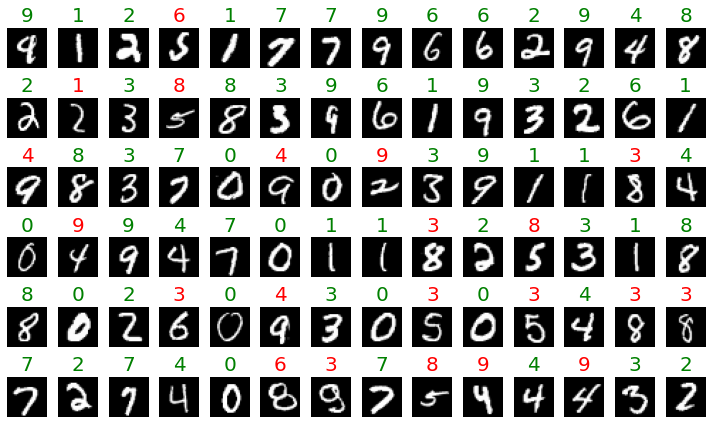

In [19]:
# Predictions on test set

plt.figure(figsize=(10,6))
n_rows = 6
n_cols = 14
model = supervised_net.cpu()
model.process_k_means(train_set.dataset)
for i, (images, labels) in enumerate(test_loader):
    if i == n_rows: break
    preds = model.classify(images).int()
    colors = [['red', 'green'][pred] for pred in (preds == labels)]
    for j in range(n_cols):
        plt.subplot(n_rows, n_cols, n_cols*i+j+1)
        plt.imshow(images[j,0], cmap='gray')
        plt.axis('off')
        plt.title(preds[j].item(), fontsize=20, color=colors[j])
plt.tight_layout(h_pad=1.5)